# Line up the time stamps of the ultima and EC systems

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [2]:
# ------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/proj/VertHarpExp2017Kloendeel/'

dirPrint = dirPre + 'graphics'
dirProcessedEC = dirPre + 'data/land_station_eddycovar_2m_processed/'
dirProcessedUltima = dirPre + 'data/DTS_UltimaVHSRE_processed'

In [3]:
# ------------------------------------------------------------------------------------------
# Load processed 2m land station eddy covariance data
os.chdir(dirProcessedEC)
ecObs = xr.open_dataset('VHRSE.eddyCovarObs_2m_land.Raw.nc')

# ------------------------------------------------------------------------------------------
# Distributed temperature sensing observations
os.chdir(dirProcessedUltima)
ultima = xr.open_dataset('VHRSE_ultima_calibrated.nc')
ultima.attrs['locations'] = ultima.attrs['locations'].split(';')

In [4]:
# ------------------------------------------------------------------------------------------
# Align the datasets

##### WARNING ######
# This is a VERY slow step. Subsampling the data to only examine the near harp.

ultimaHarpNear = None
ultimaHarpFar = None
for l in ultima.locations:
    if 'vertHarpNear' in l:
        if ultimaHarpNear:
            temp = ultima.swap_dims({'LAF': 'location'}).sel(location=l).swap_dims({'location':'LAF'})
            ultimaHarpNear = xr.concat([ultimaHarpNear, temp], dim='LAF')
        else:
            ultimaHarpNear = ultima.swap_dims({'LAF': 'location'}).sel(location=l).swap_dims({'location':'LAF'})

    if 'vertHarpFar' in l:
        if ultimaHarpFar:
            temp = ultima.swap_dims({'LAF': 'location'}).sel(location=l).swap_dims({'location':'LAF'})
            ultimaHarpFar = xr.concat([ultimaHarpFar, temp], dim='LAF')
        else:
            ultimaHarpFar = ultima.swap_dims({'LAF': 'location'}).sel(location=l).swap_dims({'location':'LAF'})
            
# Reindex ultima to the same time stamp as the sonic
ultimaHarpNear_20Hz = ultimaHarpNear.reindex_like(ecObs)
ultimaHarpFar_20Hz = ultimaHarpFar.reindex_like(ecObs)

# Interpolate Ultima to 20Hz
for LAF in ultimaHarpNear.LAF:
    tempDataCoarse = ultimaHarpNear.sel(LAF=LAF)

    # Near harp -- manually calibrated temperature
    tempDataFine = np.interp(ecObs.time, tempDataCoarse.time, tempDataCoarse.manualTemp, left=np.nan, right=np.nan)
    ultimaHarpNear_20Hz.manualTemp.loc[dict(LAF=LAF)] = tempDataFine

    # Near harp -- default temperature
    tempDataFine = np.interp(ecObs.time, tempDataCoarse.time, tempDataCoarse.defaultTemp, left=np.nan, right=np.nan)
    ultimaHarpNear_20Hz.defaultTemp.loc[dict(LAF=LAF)] = tempDataFine

for LAF in ultimaHarpFar.LAF:
    tempDataCoarse = ultimaHarpFar.sel(LAF=LAF)

    # Far harp -- manually calibrated temperature
    tempDataFine = np.interp(ecObs.time, tempDataCoarse.time, tempDataCoarse.manualTemp, left=np.nan, right=np.nan)
    ultimaHarpFar_20Hz.manualTemp.loc[dict(LAF=LAF)] = tempDataFine

    # Far harp -- default temperature
    tempDataFine = np.interp(ecObs.time, tempDataCoarse.time, tempDataCoarse.defaultTemp, left=np.nan, right=np.nan)
    ultimaHarpFar_20Hz.defaultTemp.loc[dict(LAF=LAF)] = tempDataFine
    
print(ultimaHarpNear_20Hz)
print(ultimaHarpFar_20Hz)

<xarray.Dataset>
Dimensions:        (LAF: 46, time: 2745064)
Coordinates:
  * time           (time) datetime64[ns] 2017-09-04T00:00:00.050000 ...
  * LAF            (LAF) float64 47.35 47.48 47.6 47.73 47.86 47.98 48.11 ...
    location       (LAF) object 'vertHarpNear_1' 'vertHarpNear_1' ...
Data variables:
    manualTemp     (time, LAF) float64 nan nan nan nan nan nan nan nan nan ...
    defaultTemp    (time, LAF) float64 nan nan nan nan nan nan nan nan nan ...
    probeWarmBath  (LAF, time) float64 nan nan nan nan nan nan nan nan nan ...
    probeColdBath  (LAF, time) float64 nan nan nan nan nan nan nan nan nan ...
    fiberStatus    (LAF, time) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    LAF_beg:    -83.055
    LAF_end:    449.746
    dLAF:       0.127
    locations:  ['vertHarpNear_1', 'vertHarpNear_2', 'vertHarpNear_3', 'vertH...
<xarray.Dataset>
Dimensions:        (LAF: 46, time: 2745064)
Coordinates:
  * time           (time) datetime64[ns] 2017-09-04T00:00:

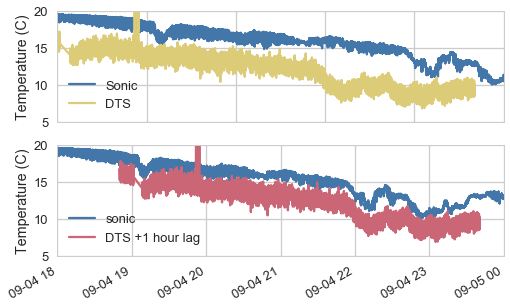

In [5]:
colors = kgraph.SRON(3)
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

# Example of the temperature data -- arbitrary segment.
ax = axes[0]
ax.plot(ecObs.time, ecObs.S1_Ts, color=colors[0], label='Sonic')
ax.plot(ultimaHarpNear_20Hz.time, ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).\
         sel(location='vertHarpNear_1').swap_dims({'location': 'LAF'}).isel(LAF=[0]).values,
        label='DTS', color=colors[1])

fig.autofmt_xdate()
ax.legend()
ax.set_xlim(datetime(2017, 9, 4, 18, 0, 0), datetime(2017, 9, 4, 23, 0, 0))
ax.set_ylim(5, 20)
ax.set_ylabel('Temperature (C)');

# Plot the data, but with an hour offset
ax = axes[1]
ax.plot(ecObs.time, ecObs.S1_Ts, color=colors[0], label='sonic')
ax.plot(ultimaHarpNear_20Hz.time
         + pd.Timedelta('1 hours'), ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).\
         sel(location='vertHarpNear_1').swap_dims({'location': 'LAF'}).isel(LAF=[0]).values,
        color=colors[2], label='DTS +1 hour lag')
fig.autofmt_xdate()
ax.legend()
ax.set_xlim(datetime(2017, 9, 4, 18, 0, 0), datetime(2017, 9, 5, 0, 0, 0))
ax.set_ylim(5, 20)
ax.set_ylabel('Temperature (C)');


Based on this I am seeing 2 things:  
1) The DTS is lagged by about 1 hour from the sonic  
2) The DTS is biased  

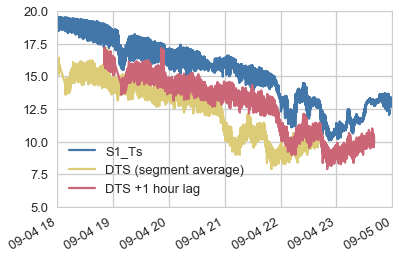

In [6]:
# Same as above, but averaging over an entire segment
colors = kgraph.SRON(3)

plt.plot(ecObs.time, ecObs.S1_Ts, color=colors[0])
plt.plot(ultimaHarpNear_20Hz.time,
         ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).
         sel(location='vertHarpNear_1').mean(dim='location').values,
         color=colors[1], label='DTS (segment average)')
plt.gcf().autofmt_xdate()
plt.gca().set_xlim(datetime(2017, 9, 4, 18, 0, 0), datetime(2017, 9, 5, 0, 0, 0))
plt.gca().set_ylim(5, 20)

# Plot the data, but with an hour offset
plt.plot(ultimaHarpNear_20Hz.time
         + pd.Timedelta('1 hours'), ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).
         sel(location='vertHarpNear_1').mean(dim='location').values,
         color=colors[2], label='DTS +1 hour lag')
plt.gca().legend()

Using a spatial average reduces the noise (as expected) and I think makes it clear that the data is offset by ~1 hour.

In [7]:
# Pull out the two above DTS temperature time series to work on
segmentSignal = ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).\
                sel(location='vertHarpNear_1').mean(dim='location').squeeze()
    
binSignal = ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).\
                sel(location='vertHarpNear_1').swap_dims({'location': 'LAF'}).isel(LAF=[0]).squeeze()

# Subset the time series for efficiency
d1 = datetime(2017, 9, 4, 17, 0, 0)
d2 = datetime(2017, 9, 5, 2, 0, 0)
dRange = pd.date_range(d1, d2, freq='50ms')
segmentSignal = segmentSignal.sel(time=slice(d1, d2))
binSignal = binSignal.sel(time=slice(d1, d2))

# Sonic data
sonicSignal = ecObs.S1_Ts.sel(time=slice(d1, d2))

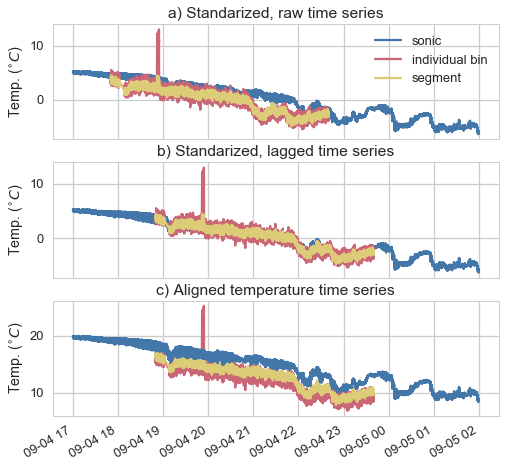

In [8]:
# Lag analysis
from scipy.signal import correlate

# Create time series
a_sig = (sonicSignal - np.nanmean(sonicSignal.values)).values
b_sig = (segmentSignal - np.nanmean(segmentSignal.values)).values
c_sig = (binSignal - np.nanmean(binSignal.values)).values

# Find nans
nandex = np.flatnonzero((np.isnan(b_sig)))
# zero them (NOT remove)
b_sig[nandex] = 0
# lag is of length len(a_sig) + len(b_sig) + 1
lag = correlate(a_sig, b_sig)
# Convert to an index in the a/b arrays
maxLag = np.argmax(lag) - len(a_sig) - 1
# Convert to a time (minutes)
maxLag_minutes = maxLag / (20 * 60)
# Remove the nans again for plotting
b_sig[np.flatnonzero(b_sig == 0)] = np.nan
c_sig[np.flatnonzero(c_sig == 0)] = np.nan

fig, axesTs = plt.subplots(3, 1, figsize=(8, 8))
ax = axesTs[0]

# Original time series with mean removed (standardized)
ax.plot(dRange, a_sig, label='sonic', color=colors[0])
ax.plot(dRange, c_sig, label='individual bin', color=colors[2])
ax.plot(dRange, b_sig, label='segment', color=colors[1])

ax.legend()
ax.set_title('a) Standarized, raw time series')
ax.set_ylabel('Temp. ($^{\circ} C$)')
fig.autofmt_xdate()

# Time series at maximum convolution/lag
ax = axesTs[1]

ax.plot(dRange, a_sig, label='sonic', color=colors[0])
ax.plot(dRange + pd.Timedelta(str(maxLag_minutes) + ' minutes'), c_sig, label='individual bin', color=colors[2])
ax.plot(dRange + pd.Timedelta(str(maxLag_minutes) + ' minutes'), b_sig, label='segment', color=colors[1])

ax.set_title('b) Standarized, lagged time series')
ax.set_ylabel('Temp. ($^{\circ} C$)')

# Re-plot lagged timeseries
ax = axesTs[2]
ax.plot(binSignal.time + pd.Timedelta(str(maxLag_minutes) + ' minutes'), binSignal.values, color=colors[2])
ax.plot(segmentSignal.time + pd.Timedelta(str(maxLag_minutes) + ' minutes'), segmentSignal.values, color=colors[1])
ax.plot(sonicSignal.time, sonicSignal.values, color=colors[0])

ax.set_title('c) Aligned temperature time series')
ax.set_ylabel('Temp. ($^{\circ} C$)')
fig.autofmt_xdate()

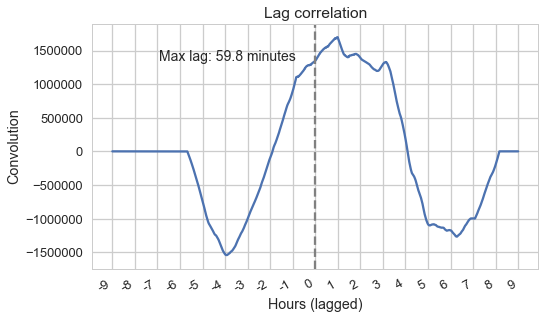

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(lag)
ax.plot([len(lag) / 2, len(lag) / 2], [min(lag) - 200000, max(lag) + 200000], '--', color='0.5')
ax.text( 0.15, 0.85, 'Max lag: ' + '{:04.1f}'.format(maxLag_minutes) + ' minutes',
        transform=ax.transAxes, fontdict={'fontsize': 14})

ax.set_ylim(min(lag) - 200000, max(lag) + 200000)
ax.set_title('Lag correlation')
hours = np.arange(0, len(lag), 20 * 60 * 60);
ax.set_xticks(hours)
ax.set_xticklabels(np.arange(0, len(hours)) - 9);
ax.set_xlabel('Hours (lagged)')
ax.set_ylabel('Convolution')
fig.autofmt_xdate()


Finally got this working. The critical piece is to not _remove_ bad values (e.g., nans) but to zero pad them. Christoph's code was a huge help in figuring this out.

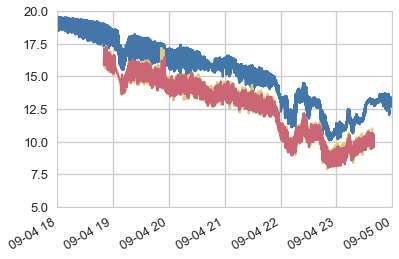

In [10]:
# if statement to prohibit multiple time lag corrections by re-running code block
lagCorrection = True
if lagCorrection:
    # Correct the Ultima data
    
    # Near harp
    ultimaHarpNear_20Hz['time'] = ultimaHarpNear_20Hz.time + pd.Timedelta(str(maxLag_minutes) + ' minutes')
    ultimaHarpNear['time'] = ultimaHarpNear.time + pd.Timedelta(str(maxLag_minutes) + ' minutes')

    # Far harp
    ultimaHarpFar_20Hz['time'] = ultimaHarpFar_20Hz.time + pd.Timedelta(str(maxLag_minutes) + ' minutes')
    ultimaHarpFar['time'] = ultimaHarpFar.time + pd.Timedelta(str(maxLag_minutes) + ' minutes')
        
    # Same as above, but averaging over an entire segment
    colors = kgraph.SRON(3)

    plt.plot(ecObs.time, ecObs.S1_Ts, color=colors[0])
    plt.plot(ultimaHarpNear_20Hz.time,
             ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).
             sel(location='vertHarpNear_1').mean(dim='location').values,
             color=colors[1], label='Near Harp (segment average)')
    plt.plot(ultimaHarpFar_20Hz.time,
             ultimaHarpFar_20Hz.manualTemp.swap_dims({'LAF': 'location'}).
             sel(location='vertHarpFar_1').mean(dim='location').values,
             color=colors[2], label='DTS (segment average)')
    plt.gcf().autofmt_xdate()
    plt.gca().set_xlim(datetime(2017, 9, 4, 18, 0, 0), datetime(2017, 9, 5, 0, 0, 0))
    plt.gca().set_ylim(5, 20)
    
    # Save this output for quicker use in the future (may not need?)
    os.chdir(dirPre + 'data')
    ultimaHarpNear_20Hz.to_netcdf('ultimaHarpNear.eddyCovarAligned.nc')
    ultimaHarpFar_20Hz.to_netcdf('ultimaHarpFar.eddyCovarAligned.nc')
    
    lagCorrection = False

# MRD on the eddy-covariance and DTS data

In [11]:
def multires_2var(a, b, M): 
    # Force deep copies of the a and b containers in case we are passing the same variable for both
    import copy
    a = copy.copy(a)
    b = copy.copy(b)
    
    # Preallocate matrices
    avg_a = np.ones((M + 1, 2**M))
    avg_b = np.ones((M + 1, 2**M))
    D = np.ones((M)) * -9999

    for inverseModeNum in np.arange(M + 1, dtype='int'):
        modeNum = M - inverseModeNum
        # Length of the decomposition mode window
        windowLength = 2**modeNum
        # Number of the decomposition mode windown
        windowNum = (2**M) / windowLength
        # Sum of the decomposition modes (for power spectrum)
        sumab = 0

        for windex in np.arange(windowNum, dtype='int'):
            # Window indices for summing
            startIndex = (windex * windowLength)
            endIndex = (windex * windowLength) + windowLength

            # Sums over the entire window length
            za = np.mean(a[startIndex:endIndex])
            zb = np.mean(b[startIndex:endIndex])

            # Store avg
            avg_a[inverseModeNum, windex] = za
            avg_b[inverseModeNum, windex] = zb

            # Sums covariance due to window means
            sumab = sumab + za * zb

            # Removes window avg for next modes
            a[startIndex:endIndex] = a[startIndex:endIndex] - za
            b[startIndex:endIndex] = b[startIndex:endIndex] - zb

        if windowNum > 1:
            # Highest mode does not count towards spectral power (single sample)
            D[modeNum] = sumab / windowNum
    return(avg_a, avg_b, D)

## Select a single DTS bin to use for MRD analysis

Text(0.5,1,'Vertical Harp Far')

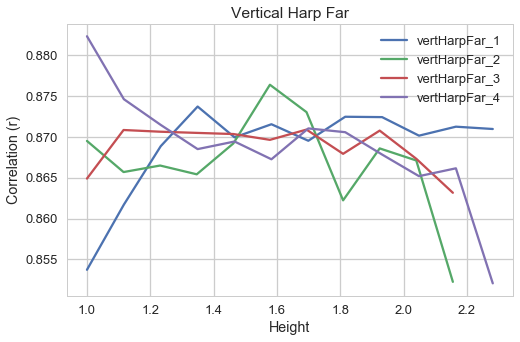

In [12]:
# ------------------------------------------------------------------------------------------
# Correlation between harp and EC
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
maxCorr = 0

for loc in ultima.locations:
    if 'vertHarpFar' in loc:
        segment = ultimaHarpFar_20Hz.swap_dims({'LAF': 'location'}).sel(location=loc).swap_dims({'location': 'LAF'})
        corrFar = []
        for loc_LAF in segment.LAF:
            # Index nans
            nandex = np.flatnonzero(~np.isnan(segment.sel(LAF=loc_LAF).defaultTemp.values))
            r = scipy.stats.pearsonr(segment.sel(LAF=loc_LAF).defaultTemp[nandex], ecObs.S1_Ts[nandex])
            
            # Keep the best correlating segment
            if r[0] > maxCorr:
                maxCorr = r[0]
                segmentFar = segment.sel(LAF=loc_LAF)
            
            # Append to list
            corrFar.append(r[0])
        
        # Height variable to plot against
        vertHeight = np.arange(1, segment.LAF.max() - segment.LAF.min() + 1,
                               (segment.LAF.max() - segment.LAF.min()) / len(segment.LAF))
        ax.plot(vertHeight, corrFar, label=loc)

# Formatting
ax.legend()
ax.set_xlabel('Height')
ax.set_ylabel('Correlation (r)')
ax.set_title('Vertical Harp Far')

Text(0.5,1,'Vertical Harp Near')

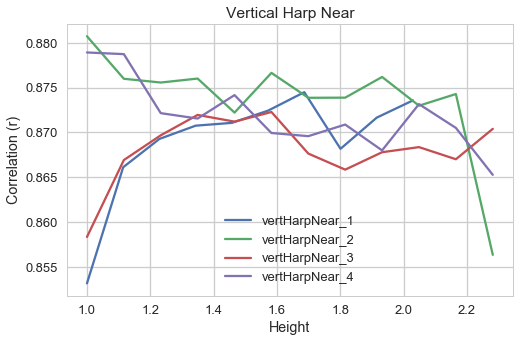

In [13]:
# ------------------------------------------------------------------------------------------
# Correlation between harp and EC
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
maxCorr = 0

for loc in ultimaHarpNear_20Hz.locations:
    if 'vertHarpNear' in loc:
        segment = ultimaHarpNear_20Hz.swap_dims({'LAF': 'location'}).sel(location=loc).swap_dims({'location': 'LAF'})
        corrNear = []
        for loc_LAF in segment.LAF:
            # Index nans
            nandex = np.flatnonzero(~np.isnan(segment.sel(LAF=loc_LAF).defaultTemp.values))
            r = scipy.stats.pearsonr(segment.sel(LAF=loc_LAF).defaultTemp[nandex], ecObs.S1_Ts[nandex])
            
            # Keep the best correlating segment
            if r[0] > maxCorr:
                maxCorr = r[0]
                segmentNear = segment.sel(LAF=loc_LAF)
            
            # Append to list
            corrNear.append(r[0])
        
        # Height variable to plot against
        vertHeight = np.arange(1, segment.LAF.max() - segment.LAF.min() + 1,
                               (segment.LAF.max() - segment.LAF.min()) / len(segment.LAF))
        ax.plot(vertHeight, corrNear, label=loc)

# Formatting
ax.legend()
ax.set_xlabel('Height')
ax.set_ylabel('Correlation (r)')
ax.set_title('Vertical Harp Near')

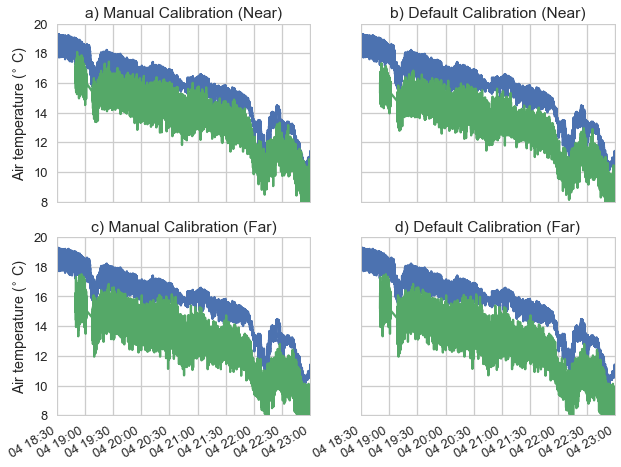

In [18]:
# Compare DTS to EC
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey='row', sharex='col')
axes = axes.flatten()
d1 = datetime(2017, 9, 4, 18, 30, 0)
d2 = datetime(2017, 9, 4, 23, 0, 0)
dRange = pd.date_range(d1, d2, freq='50ms')

ax = axes[0]
ax.plot(ecObs.time.values, ecObs.S1_Ts)
ax.plot(segmentNear.time.values, segmentNear.manualTemp)
ax.set_ylabel('Air temperature ($^{\circ}$ C)')
ax.set_title('a) Manual Calibration (Near)')
ax.set_xlim(d1, d2)
ax.set_ylim(8, 20)

ax = axes[1]
ax.plot(ecObs.time.values, ecObs.S1_Ts)
ax.plot(segmentNear.time.values, segmentNear.defaultTemp)
ax.set_title('b) Default Calibration (Near)')
ax.set_xlim(d1, d2)
ax.set_ylim(8, 20)

ax = axes[2]
ax.plot(ecObs.time.values, ecObs.S1_Ts)
ax.plot(segmentFar.time.values, segmentFar.defaultTemp)
ax.set_ylabel('Air temperature ($^{\circ}$ C)')
ax.set_title('c) Manual Calibration (Far)')
ax.set_xlim(d1, d2)
ax.set_ylim(8, 20)

ax = axes[3]
ax.plot(ecObs.time.values, ecObs.S1_Ts)
ax.plot(segmentFar.time.values, segmentFar.defaultTemp)
ax.set_title('d) Default Calibration (Far)')
ax.set_xlim(d1, d2)
ax.set_ylim(8, 20)

fig.autofmt_xdate()

In [ ]:
# Run MRD for DTS and sonic
numScales = 11
numHours = 5
scales = 2**(np.arange(numScales))
tIndexBeg = np.arange(0, (numHours) * 3600, 3600)
spectraEC1 = np.zeros((numScales, len(tIndexBeg)))
spectraEC2 = np.zeros((numScales, len(tIndexBeg)))

for tNum, beg in enumerate(tIndexBeg):
    mrd_length = beg + 2 ** numScales
    end = int(beg + mrd_length) + 1
    if end > len(ecObs.time):
        end = len(ecObs.time)
    signal1 = sonic1[int(beg): end]
    avg, _, spectraEC1[:, tNum] = multires_2var(signal1, signal1, numScales)
    spectraEC1[:, tNum] = spectraEC1[:, tNum] * scales
    
    
    signal2 = sonic2[int(beg): end]
    avg, _, spectraEC2[:, tNum] = multires_2var(signal2, signal2, numScales)
    spectraEC2[:, tNum] = spectraEC2[:, tNum] * scales
